In [ ]:
# create a spherical harmonic from a chromeball image

import os
import numpy as np 
import skimage
from scipy.ndimage import distance_transform_edt
from multiprocessing import Pool 
from tqdm.auto import tqdm
from sh_utils import get_shcoeff, unfold_sh_coeff, flatten_sh_coeff

INPUT_DIR = "/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/"
OUTPUT_DIR = "./shcoeffs/"

def process_file(image_name):
    
    image = skimage.io.imread(os.path.join(INPUT_DIR, image_name))
    image = skimage.img_as_float(image)
    print(np.max(image), np.min(image), image.shape, image.dtype)
    coeff = get_shcoeff(image, Lmax=2)
    shcoeff = flatten_sh_coeff(coeff, max_sh_level=2)
    print(shcoeff.shape, shcoeff.dtype)
    np.save(os.path.join(OUTPUT_DIR, image_name.replace(".png", ".npy")), shcoeff)
    return None

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    files = sorted(os.listdir(INPUT_DIR))
    with Pool(16) as p:
        list(tqdm(p.imap(process_file, files), total=len(files)))

if __name__ == "__main__":
    main()

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 9) float64
(3, 9) float64


 20%|██        | 1/5 [00:00<00:01,  3.73it/s]

(3, 9) (3, 9)float64(3, 9)
  float64float64



100%|██████████| 5/5 [00:00<00:00, 18.11it/s]


In [13]:
import torch as pt
import numpy as np

def drawSH(sh_np, img_size=256):
    sh = pt.tensor(sh_np).view(9, 3)
    ball = drawSphere(sh, img_size)
    map, map_centered, map_clean = drawMap(sh, img_size)
    combined = pt.cat([ball, map], 2)
    # save_image(combined, output)
    # save_image(map_centered, output.replace(".png", "_centered.png"))
    return ball, map, map_centered, map_clean, combined

def drawSphere(sh, img_size=256):
  n = img_size
  xyz = genSurfaceNormals(n)
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out

def drawMap(sh, img_size=256):
    n = img_size
    lr = pt.linspace(0, 2 * np.pi, 2 * n)
    ud = pt.linspace(0, np.pi, n)
    ud, lr = pt.meshgrid(ud, lr)

    # we want to make the sphere unwrap at the center of this map,
    # so the left-most column is the furthest-away point on the sphere
    # lr going counter-clockwise = increasing in value.
    # ud starting from 0 (top) to pi (bottom).
    # Lattitude = azimuth = deg from one of xz axis
    # Longtitude = elevation = deg from y-axis
    # In standard unitsphere orientation;
    # z = up (so set y = pt(cos(ud))) ref. https://www.learningaboutelectronics.com/Articles/Spherical-to-cartesian-rectangular-coordinate-converter-calculator.php
    x = -pt.sin(ud) * pt.sin(lr)  # Negative to ensure correct left-right orientation
    y = pt.cos(ud)                # No negative sign needed for up-down orientation
    z = -pt.sin(ud) * pt.cos(lr)  # Negative to ensure correct front-back orientation

    lm = n // 2
    rm = n + (n // 2)

    out = applySHlightXYZ(pt.stack([x, y, z], 0), sh)
    out_centered = out[:, :, lm:rm].clone()
    out_clean = out.clone()
    out[:, :, lm] = pt.tensor((1, 0, 0))[:, None]
    out[:, :, rm] = pt.tensor((1, 0, 0))[:, None]
    return out, out_centered, out_clean

def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  # out /= pt.max(out)
  out *= 0.7
  return pt.clip(out, 0, 1)

def genSurfaceNormals(n):
  x = pt.linspace(-1, 1, n)
  y = pt.linspace(1, -1, n)
  y, x = pt.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  z[z < 0] = 0
  z = pt.sqrt(z)
  return pt.stack([x, y, z], 0)

def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = pt.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = pt.tensor(
    [
      1 / np.sqrt(4 * pi),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = pt.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading


(3, 9)
(256, 256, 3) 0.1642726173468411 0.0
(256, 256, 3) 41 0


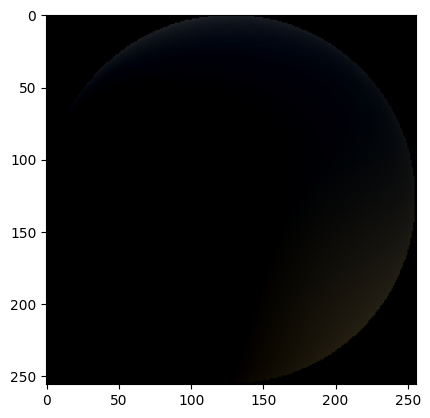

In [22]:
import matplotlib.pyplot as plt

map = '012_hdrmaps_com_free_2K.exr.npy'
sh_coeffs = np.load(f'/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/difareli++/envmap2sh/shcoeffs/{map}')
print(sh_coeffs.shape)
sh_coeffs = sh_coeffs.T
ball, map, map_centered, map_clean, combined = drawSH(sh_coeffs, img_size=256)
ball = ball.numpy().transpose(1, 2, 0)  # Convert to HWC format for visualization   

print(ball.shape, np.max(ball), np.min(ball))
ball = (ball * 255).astype(np.uint8)  # Scale to [0, 255] for display
print(ball.shape, np.max(ball), np.min(ball))
plt.imshow(ball)
plt.show()